In [85]:
import sys
import os
project_root = os.path.abspath(os.path.join(os.getcwd(), ".."))
if project_root not in sys.path:
    sys.path.append(project_root)

from src.data_io import ImageData
from cv2 import imread
import os
import glob
import numpy as np
import torch
from skimage import transform, io
import matplotlib.pyplot as plt
import matplotlib.patches as patches

import monai
import torch.nn as nn

import importlib
from src import medsam_segmentation
importlib.reload(medsam_segmentation)
from src.medsam_segmentation import MedSAMTool

In [86]:
def _get_binary_masks(nonbinary_mask):
    """ 
    Given nonbinary mask which encodes N masks, return N binary masks which
    should encode the same information.
    
    Parameters:
        - nonbinary_mask: ndarray of shape (H, W)
    Returns:
        - binary_masks: ndarray of shape (N, H, W)
    """
    print(type(nonbinary_mask), nonbinary_mask.shape)
    binary_masks = []
    for i in np.unique(nonbinary_mask)[1:]:
        binary_mask = (nonbinary_mask == i).astype(np.uint8)
        binary_masks.append(binary_mask.copy())
    binary_masks = np.stack(binary_masks, axis=0)
    print(type(binary_masks), binary_masks.shape)
    return binary_masks

In [87]:
ssh_root_dir = "/home/sstiles/sci-agent/"
validation_data_path = os.path.join(ssh_root_dir, "data/codabench_validation_data")
os.path.exists(validation_data_path)
os.listdir(validation_data_path)

img_path = os.path.join(validation_data_path, "imgs")
mask_path = os.path.join(validation_data_path, "gts")


<class 'numpy.ndarray'> (512, 512)
<class 'numpy.ndarray'> (3, 512, 512)


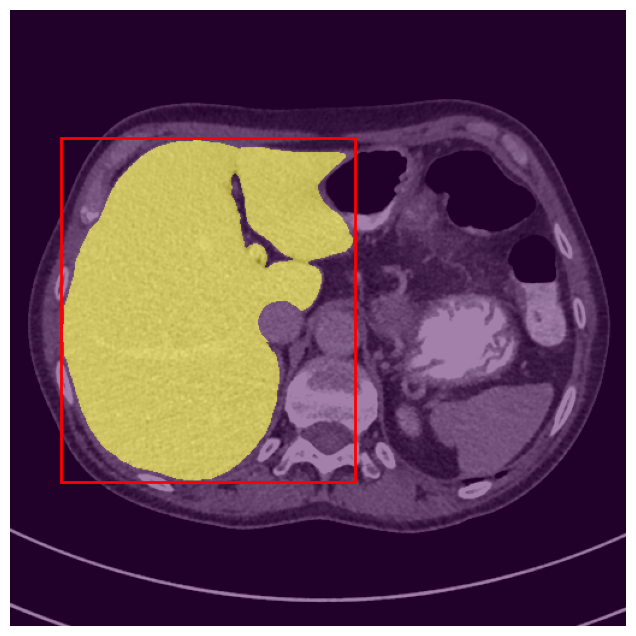

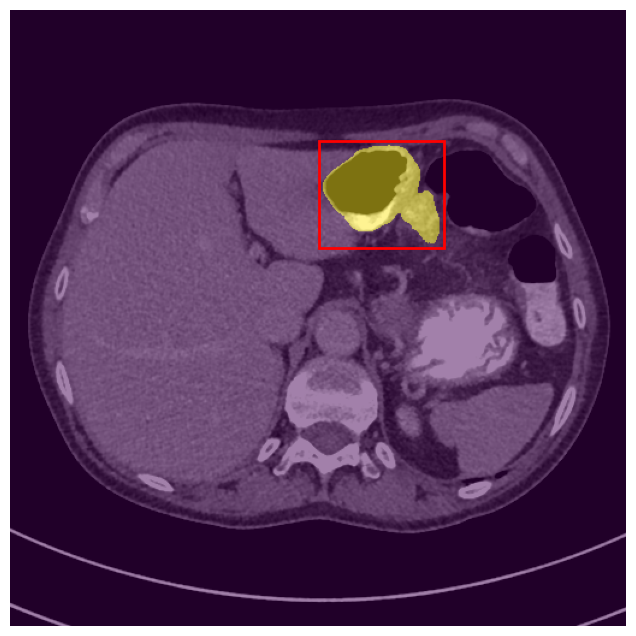

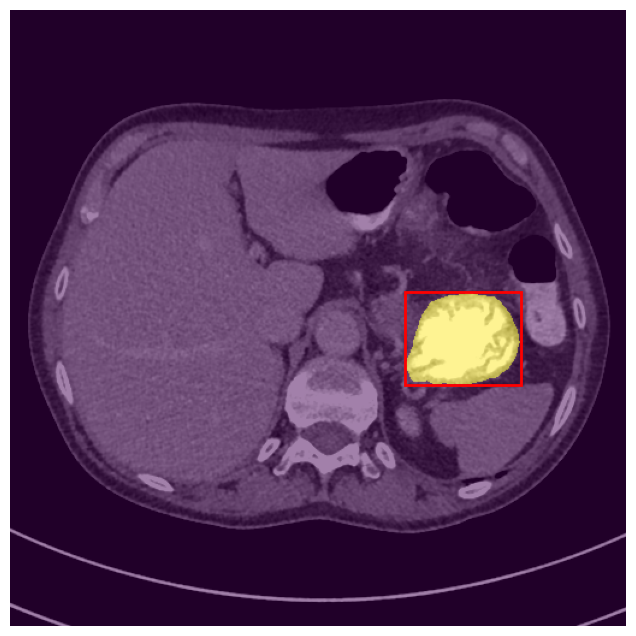

In [88]:
num_files = 1

img_files = sorted(glob.glob(os.path.join(img_path, '*')))[:num_files]  # list of strings
mask_files = sorted(glob.glob(os.path.join(mask_path, '*')))[:num_files]

raw_images, raw_boxes, raw_masks = [], [], []
for img_npz_file, mask_npz_file in zip(img_files, mask_files):
    img_data, mask_data = np.load(img_npz_file), np.load(mask_npz_file)  
    
    image, boxes, nonbinary_mask = img_data['imgs'], img_data["boxes"], mask_data['gts']
    binary_masks = _get_binary_masks(nonbinary_mask)
    
    for box, mask in zip(boxes, binary_masks):
        x1, y1, x2, y2 = box
        box_string = f"[{x1},{y1},{x2},{y2}]"
        
        raw_images.append(image)
        raw_boxes.append(box_string)
        raw_masks.append(mask)

# Plot input data
for (image, box_string, mask) in zip(raw_images, raw_boxes, raw_masks):
    fig, ax = plt.subplots(figsize=(8, 8))
    ax.imshow(image, cmap='gray')
    ax.imshow(mask, alpha=0.5)

    x1, y1, x2, y2 = map(int, box_string.strip('[]').split(','))
    width, height = x2 - x1, y2 - y1
    rect = patches.Rectangle((x1, y1), width, height, linewidth=2, edgecolor='r', facecolor='none')
    ax.add_patch(rect)
    ax.axis('off')

    plt.show()


images = ImageData(raw=raw_images,
                batch_size=1,
                image_ids=[i for i in range(len(raw_images))],
                masks=raw_masks,
                predicted_masks=raw_masks)

In [ ]:
checkpoint_path = os.path.join(project_root, "data/medsam_vit_b.pth")
# print(os.path.exists(checkpoint_path))

medsam_tool = MedSAMTool(gpu_id=0, checkpoint_path=checkpoint_path)
pred_masks = medsam_tool.predict(images)



In _build_sam() with cuda:0
type of mask <class 'numpy.ndarray'>
type of mask <class 'numpy.ndarray'>
type of mask <class 'numpy.ndarray'>


immediate_loss tensor(0.9966)
immediate_loss tensor(0.9996)
immediate_loss tensor(0.9995)


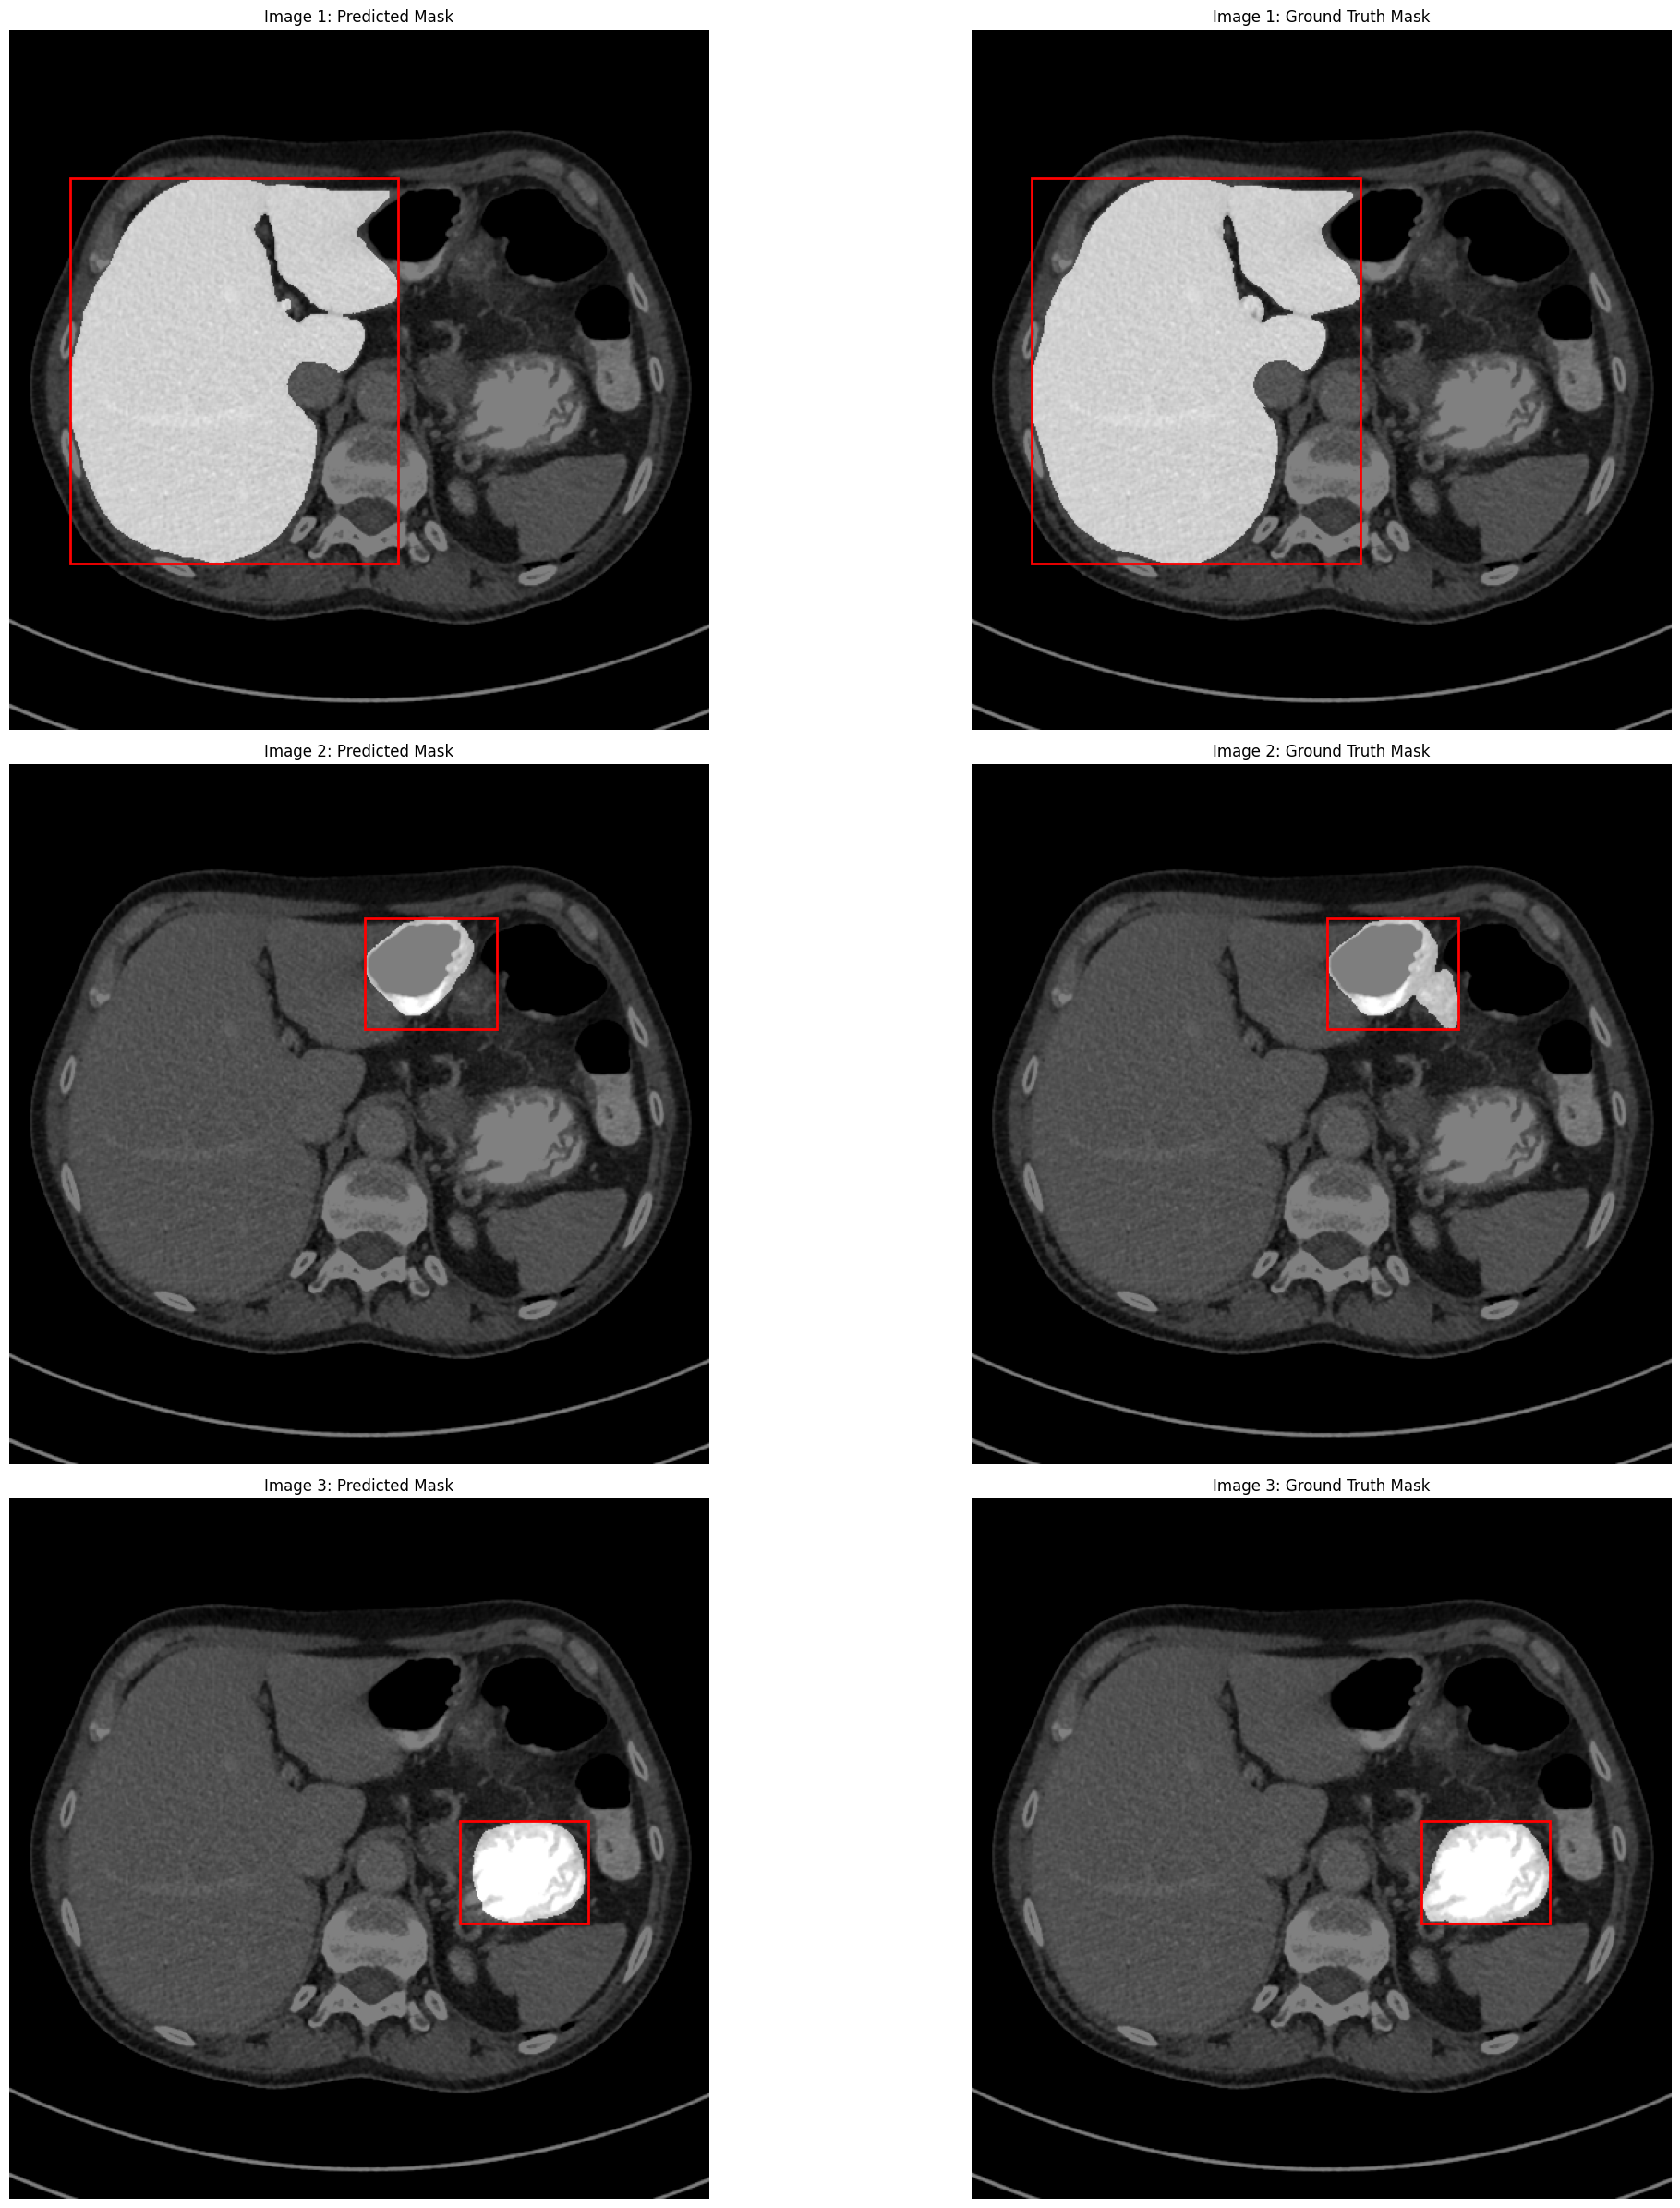

In [90]:
gt_masks_list = images.masks
losses = medsam_tool.evaluate(pred_masks, gt_masks_list)
medsam_tool.visualize(images, pred_masks, gt_masks_list)